Hello, in this article, I'll be going through a geo-spatial data science project of my exploration of traffic volume statistics in New York City.
Apart from python, this project requires having ArcGIS, specifically the software ArcMap.

This article will have 4 parts:
1. Data Preparation in ArcGIS 
2. Data Cleaning
3. EDA and Hypothesis Testing
4. Prediction with basic machine learning

## Part 1: Data Preparation in ArcGIS

First, we'll need 3 **base datasets** taken from online.
* A dataset tracking hourly traffic volume in New York City streets over a period of time 

https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2014-2019-/ertz-hr4r
* A dataset that will help us map the New York City street ID's to their exact location

https://data.cityofnewyork.us/City-Government/LION/2v4z-66xt
* A dataset that shows the Landuse and census parcels of New York City

https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

### Part 1 A. Data Preparation in ArcGIS: *Getting the Street Segment Traffic Data into a GIS-friendly Format*

Opening the traffic CSV file (the first base dataset) on ArcMap, you'll come across the first problem. **There is no geospatial data usable with this csv file**. The closest column we have are the street names, which is a bad thing to resort to, since string data like this can be wildly inconsistent from one data source to another (East 73rd Street in one CSV might be 73 St. E in another).

But there's no reason to panic. Luckily, the metadata for that traffic CSV file shows that the column "Segment ID" is an identifier for each street segment. After some internet sleuthing, you will eventually find an online data source with a name like "nyc_lion" (the second base dataset), which has extensive data on NYC street segments, including a column with the exact same identifier. Most importantly, it includes shapefiles that will allow us to use geospatial data. 

* Download the nyclion dataset, and open up it on ArcMaps. 
* Drag the "lion" layer into ArcMaps from the catalog. This will show a comprehensive polyline street map of New York City. This is the only layer we will actually need from nyclion; the rest of the data folder wastes up a lot of storage, so export the lion layer as a lone shape file and delete the other stuff. So now, we just have the lion shapefile, and the traffic csv. #12

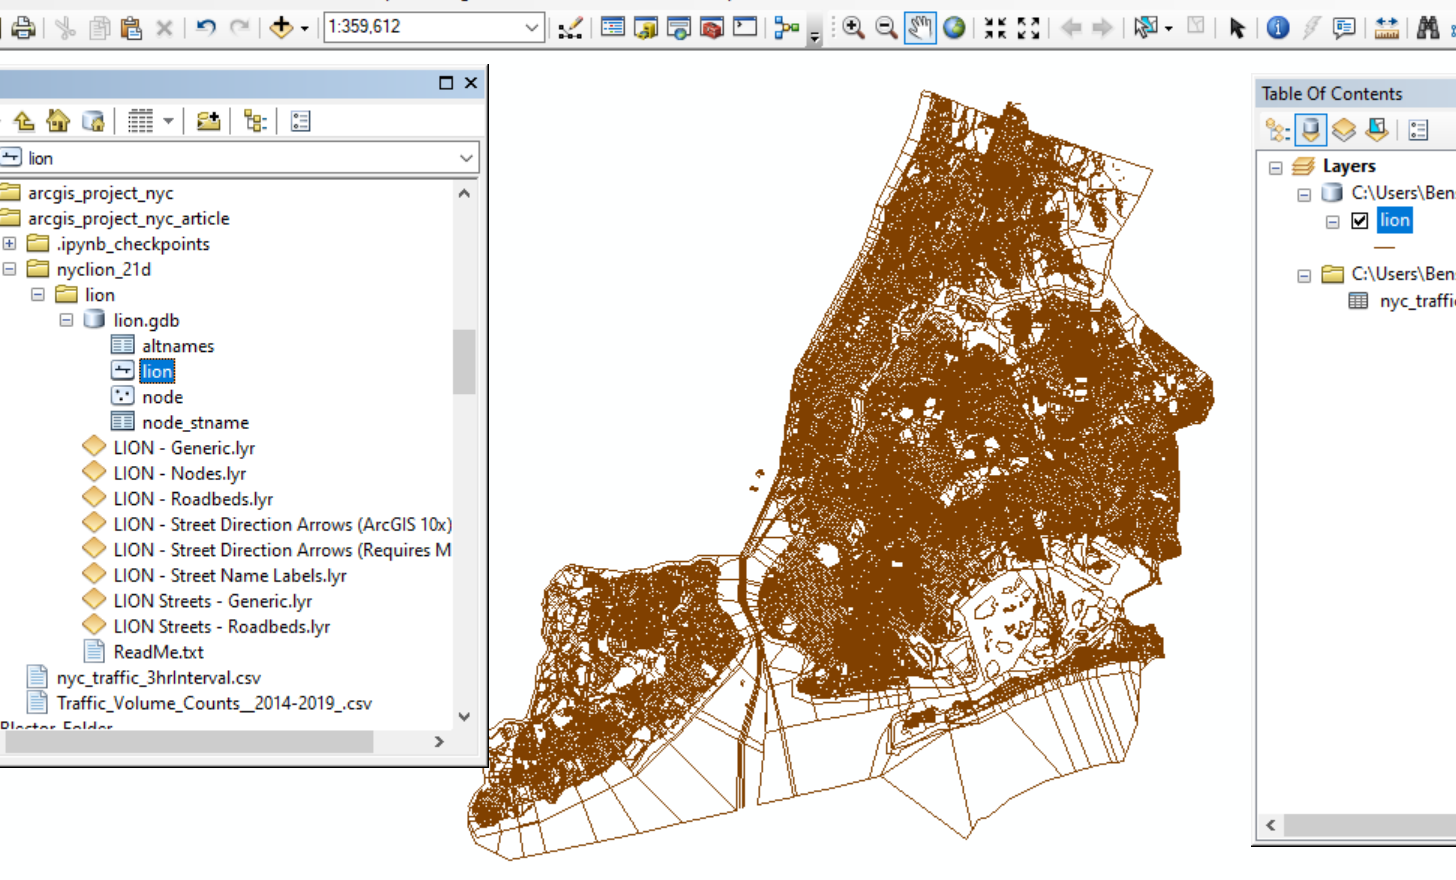

Now, we must do a join between the shapefile dataframe and the csv dataframe on the foreign key Segment ID. But there's a side-issue that must be resolved first. In the traffic csv layer, the Segment ID's type is a long integer. Meanwhile, in the lion shapefile layer, the Segment ID is a 7-character string that's zero-padded in the front. This formatting difference will ruin the join.

This can be resolved by making a new column with the correctly formatted segment ID. 
* Add a new 7-digit, long-integer field to the dataframe of the lion shapefile layer with the name "Segment_ID"
* Use the field calculator to convert that string column to a long integer. 
* I used the python calculator, and used the code int(!SegmentID!).

Now that's been settled, you can go ahead with the join. But after running, you'll notice a problem is that this tool will only treat it as one-to-one, keeping only the first matching row it finds per street segment, and ignoring the duplicate rows after. This means that each street segment row will have just the first hour of the day, rather than all of them. It needs to be a one-to-many join, because each street segment has many rows describing its traffic volume at different times of the day. **However, we won't delete this failed join layer**. It will be useful later, so rename it as something like "OneToOneJoin" and tuck it away for now.

According to Esri, going to ArcToolbox > Layers and Table Views > Make Query Table will provide an alternative join tool that resolves one-to-many. However, this method did not work for me, so I'll provide another way.
According to this forum post: https://gis.stackexchange.com/questions/177506/one-to-many-joins-on-a-feature-class-to-a-table, to do a one-to-many join:
* Create a file geodatabase in the ArcMap file. 
* From the geodatabase, import the 2 main layers from earlier, which are the lion shp file (as a feature class (single)), and the traffic csv file (as a table (single)). 
* Finally, using those 2, imported layers ***within*** the geodatabase, perform a join with ArcGIS's regular inbuilt join tool.
* The resulting layer (which I renamed to "gdb_join") will deceptively appear the same as the first failed One-to-One join Layer. 
* **But**, once this layer gets exported as a shp.file and then re-added back into the ArcMap file, it will show all the hours for each street segment, i.e. a proper one-to-many join.

That final, resulting join layer ("gdb_join") should appear like this (It does not need to be green). All the other layers were hidden and a BaseMap was added underneath to show the purpose of this join. #40

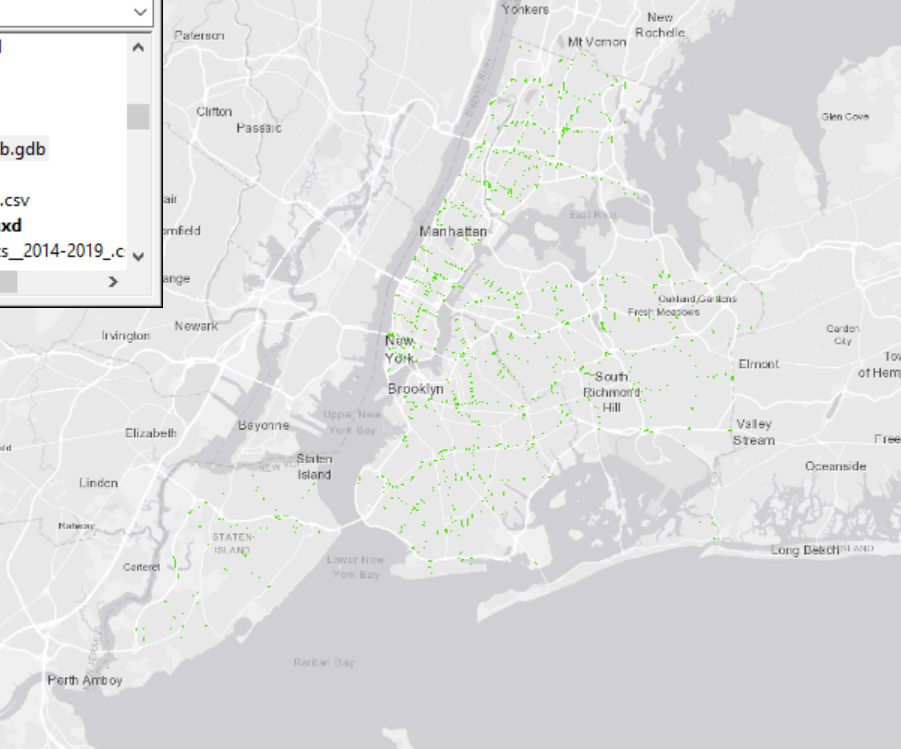

In summary, for the 1st base dataset listed at the beginning, we had to join it with the 2nd base dataset, so that its street segment traffic data could be geospatially usable and visually seen when loaded up onto ArcMap.

### Part 1 B. Data Preparation in ArcGIS: *Retrieval of Geospatial Data Surrounding the Street Segments*

We could move onto data-cleaning and wrap up ArcGIS, but we could also go a bit further. So far, we have data on **time** (hourly traffic data) and **place** (street segment), which are very useful for analyzing traffic. But could **place** be improved? Specifically, could more be done to learn about a street segment's **surroundings** and **local environment**?

Environmental context can imply a lot about the traffic volume; for example, if the street segment's **local surrounding area** is mostly residential, like say, Queens or Staten Island, you likely won't see noisy urban traffic.

* But the issue is definining the **local surrounding area** that a street segment falls within. NYC has many subdivision types for us to use, like census tract, zip code, community districts (CT), neighborhood tabulation areas (NTA), even congressional districts and school districts.
* But, ... the issue is that these all suffer from the **Modifiable Areal Unit Problem**; they are are human-created, and thus unequally shaped and sized, and overall arbitrary.
* A better, un-biased solution is to define the "surrounding area" as a region drawn around the street segment at a certain radius. For example, 500 feet.

This is the goal of Part 1B:
* For each of the street segments in the gdb_join dataframe,
* Draw  a region that's X distance radius around the street segment (which I chose X as 500 ft, but its up to personal choice)
* That way, later on in the project, we can gather up all data on the buildings/land-parcels within that region to form statistics for that street segment.

For New York City, data for land-parcels is available in the 3rd base dataset (named MapPluto).
* Load the shapefile up
* Rename this shapefile layer as "LandUse".

Zooming in, the LandUse shapefile layer (pink) represents the parcels and lots on each city-block. The lion shapefile layer (dark red), and the new gdb_join shapefile layer (bright green) are also shown. #55

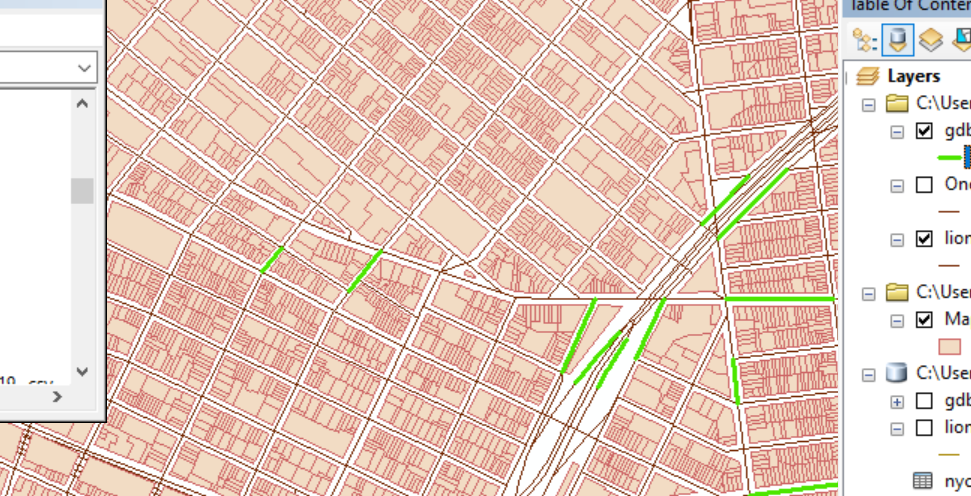

Remember that "failed" OneToOneJoin shapefile layer created back then? This is when it gets used again.
Use the Geoprocessing > Buffer Tool with the following parameters:
* Input Features: the "failed" one-to-one join layer from earlier.
* Distance [value or field]: set to 500, with units as Feet (This radius is arbitrary)
* Dissolve: None

Run the buffer tool, and rename the resulting layer as "StreetSegmentBlobs". You should have a result like this: These "blobs" are the area 500ft around the the street segment. The reason that the "Failed join" layer ("OneToOneJoin" layer) was used is to avoid having redundant "blobs" stacked onto each other; only 1 is necessary for each street segment. #58

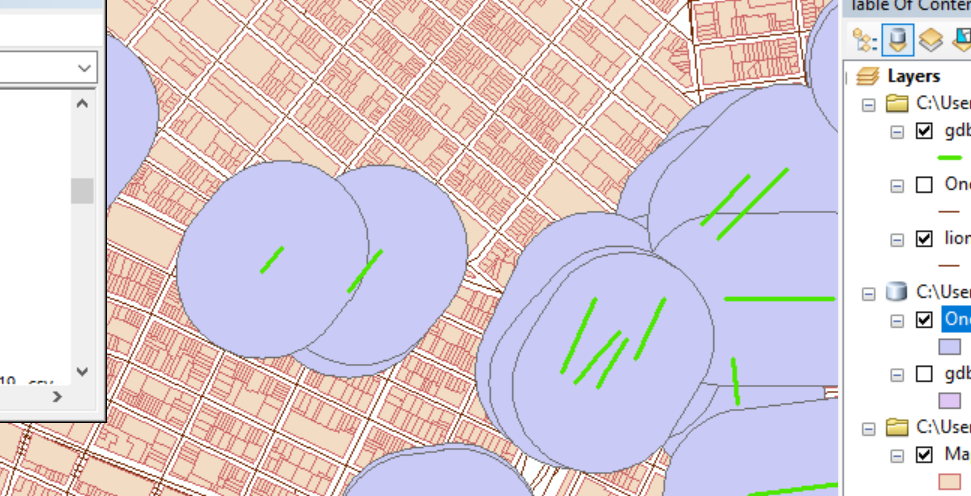

Next, use the Geoprocessing > Clip tool with the following parameters:
* Input Features: the new LandUse dataframe layer
* Clip Features: the StreetSegmentBlobs Layer from the last step

Run the Clip tool, which might take a while. Name the new clipped layer as StreetSegment_LandUse_Clipped. #79

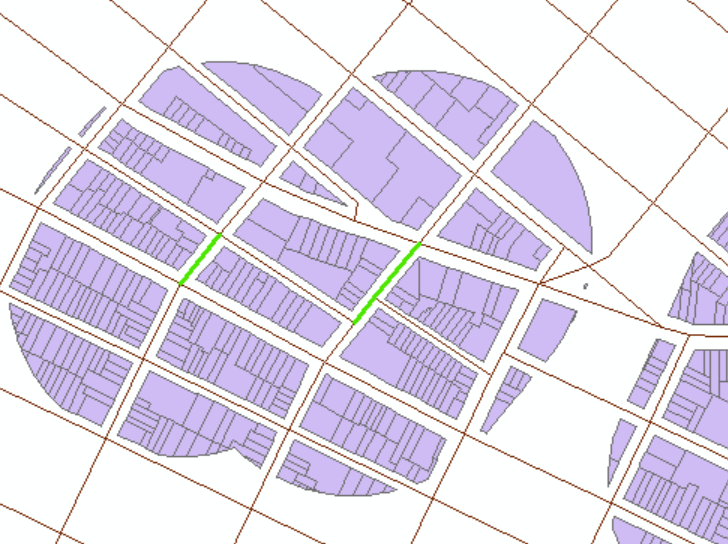

Finally, use the Customize > ArcToolbox > Analysis Tools > Overlay > Spatial Join tool with the following parameters:
* Target Features: the LandUse_StreetSegmentBlobs_Clipped layer
* Join Features: the StreetSegmentBlobs layer
* Join Operation: One to Many
* Match Option: Intersect

Name the resulting layer as StreetSegment_LandUse_Subsets, and export the dataframe of it to a txt file for later use as a CSV.

So now, if you select say, street segment 30786, it is tied to these buildings: #80

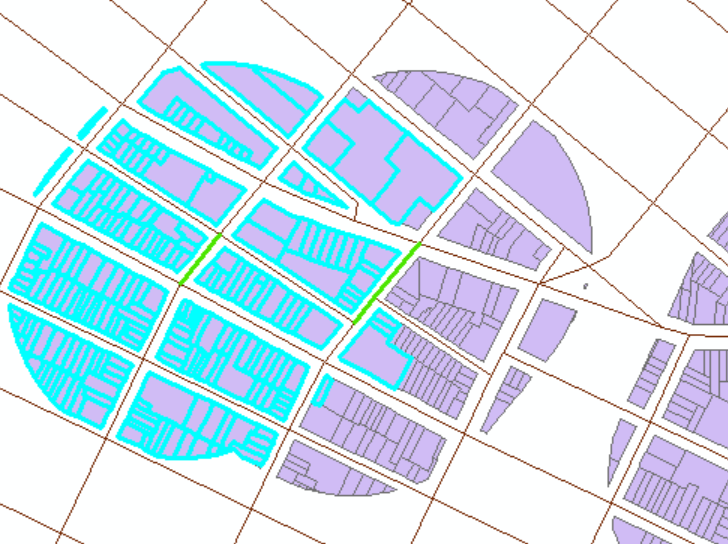

If you select instead say, street segment 30800, it is tied to these buildings: #81

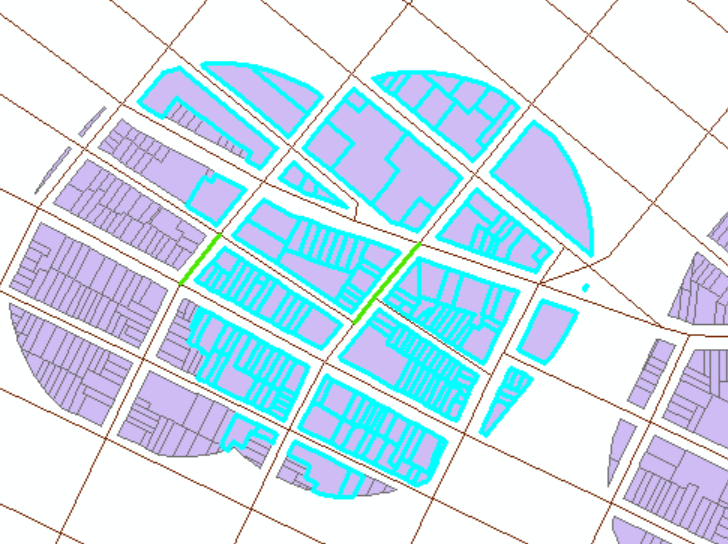

The ArcGIS portion is complete: each street segment now has its little carved-out, 500ft-radius subset of New York City! But remember, this was done with the OneToOneJoin. So later on, we have to rejoin this layer with the gdb_join dataframe. But that can easily be done on pandas, outside of ArcGIS.

### [Optional] Part 1 C: Data Preparation in ArcGIS: *Getting Subway Proximity*

For each street segment, we'd like to calculate it's distance to all NYC subway entrances:
The subway entrance dataset:
https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56

Load the shapefile onto the same ArcMap file.
Use the Customize > ArcToolbox > Analysis Tools > Proximity > Generate Near Table tool with the following parameters:
* Input Features: the OneToOneJoin shapefile layer
* Near Features: the new Subway Entrances shapefile layer
* Turn off the box that says to only include the nearest subway station

Run it. It will take awhile since it's very computationally expensive, but once it's done, export the new table as a txt file under the name "Subway_Entrances".

## Part 2: Data Cleaning

By now, there should be 2 new tables created after the ArcGIS part:
* **gdb_join** is a table for certain street segments in New York City, with each street segment having information on the traffic volume during different parts of the day.
* **StreetSegment_LandUse_Subsets** is a table of the surrounding geospatial information (municipal land-use) of each street segments. Specifically, it shows within the 500-foot radius of the street segment

 We will decide to collapse StreetSegment_LandUse_Subsets so that each street segment has 1 row, essentially aggregating all the info about the street segment's nearby surroundings into 1 compact row.

Both tables have more than 100 columns, so there's a lot of information we don't really need. This next part is about the data columns and selection of which columns are important, and the explained thought process behind the columns chosen.

This project is after all, about traffic in street segments in NYC. Reasonably, the most important features to determine traffic would be **"Time"** and **"Place"**.

### Part 2 A. Data Cleaning:  *Refining Data for 'Time'*
**"Time"** will be defined particularly in terms of the time of day of the traffic. This refers to the 1st **base dataset** from the beginning, Traffic, which helped to form the new table "gdb_join".
Several adjustments were done to the original traffic CSV table, mostly adding more tiers of the data granularity of time, such as time of year, time of week, and time of day.
* A categorical "Season" column was added (In this dataset, Summer seemed to be absent).
    * Season is a reasonable variable to monitor since different seasons have different weathers that might affect traffic volume (for example, traffic maybe reduced during winter due to snowy roads)
* A boolean "Is Weekend" column is added
    * Weekend is a reasonable variable to monitor since traffic may differ from the business week traffic volume.
* In the original traffic csv file, the hours of the day seem to be their own seperate columns; they were melted so that each street segment now corresponds to 24 rows.
* The hours of the day are grouped into sizes of 3 (e.g., 12am to 3 am), etc, with the traffic volume being the group's aggregated average. Now, each day has 8 subdivisions rather than 24.
    * This is entirely optional, and is mainly to speed up calculations later on.
* The table seems to have a seperate row for the 2 opposing lanes of the road; the traffic volumes for each pair were added together.

The final table, which is named as "nyc_traffic_3HrInterval", is actually the traffic CSV file used in Part 1. So to recreate this project with your own traffic csv file, it is proper to do Part 2A first, then Part 1, and then Part2B.

The resulting table is then duplicated under 2 slightly differing versions, one for Part 3 (EDA), and the other for Part 4 (ML).

**For EDA**:
* The Season column is changed from numbers to nominal labels. 1-> Winter, 2->Spring, 4->Autumn.

**For ML**:
* The Season column is converted to be One-Hot-Encoded (set of boolean columns)
* The hour column (or the 3 Hour Interval column) is converted to be One-Hot-Encoded (set of boolean columns)
    * While the 3 Hour Interval column is numerical, I'm treating it as categorical because traffic volume is fully un-related with the linearly increasing nature of the hour label. 
* [Optional] Adding a new numerical variable "Daylight" will help solve the above issue, by putting the hour column through a bell-curving function f(x) = (2)/(1 + np.exp(((x - 12)/4)^2)), transforming it to look like traffic's hump-like timeline. Because like traffic, daylight is low at the start and end of the day, but high in the middle

### Part 2 B. Data Cleaning:  *Refining Data for 'Place'*
**"Place"** will be defined particularly in terms of the nature of the surroundings, i.e. the environmental context. This refers to the 2nd and 3rd **base dataset** from the beginning, Lion and LandUse, which together helped to form the new table "StreetSegment_LandUse_Subsets". Before doing anything, join the Subway Distances table with the foreign key ORIG_FID = IN_FID.

* Lion Metadata: https://archive.nyu.edu/bitstream/2451/34565/3/lion_metadata.pdf
* LandUse Metadata: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=21v3

Reading through both the Lion and LandUse dataset's original metadata pdf files, many features aren't quite relevant to traffic, but the ones that *do* show promise, are:
* StreetWidth
* NumFloors
* UnitsRes and UnitsTotal (can be divided to show percentage of residential units)
* Borough 
    * (for higher-level granularity with geographic data)
* (and most importantly) *LandUse*. 
    * LandUse is a categorical column that designates the use of a building, for example whether it's Commercial/office, Industrial, etc. Some of the LandUse categories are redundant, and could be grouped together. For example, 01, 02, 03, and 04 can all fall under "residential".

But having all of these rows for each land parcels is not neceessary. The info for all of the buildings in a single street segment's surrounding area can be compactly summarized into 1 row through aggregation: 

* StreetWidth (mean)
* A duplicate of StreetWidth but with it standardized by z-scoring (mean)
* SubwayProximity (mean)
* UnitsRes_Prop (mean)
* NumFloors (mean)
* Borough (One Hot Encoded, then summed and then proportionalized i.e. divided by the row-wise sum)
* LandUse (One Hot Encoded, then summed and then proportionalized i.e. divided by the row-wise sum)

Try to make 2 different versions of the new dataset, one for EDA and one for predictive modelling/machine learning

**For EDA**:
* De-horizontalize the One-Hot-Encoded Borough columns back to a singular BoroCode column. The values should also be changed from numbers to nominal labels. Change 1-> Manhattan, 2-> Bronx, 3 -> Brooklyn, 4 -> Queens, 5 -> Staten Island.
* Drop the z-scored version of StreetWidth; just keep the regular version.

**For ML**:
* Drop the regular version of StreetWidth; just keep the z-scored version.
* Keep the One-Hot-Encoded Borough columns as it is, not de-horizontalized.

## Part 3: EDA and A/B Testing

The EDA portion will mostly focus on aspects of traffic volume and its relationships with other variables, and some hypothesis testing.
* InnerJoin the data-cleaned EDA table of gdb_join, and the data-cleaned EDA table of StreetSegment_LandUse_Subsets from part 2 on Segment_ID.

During weekdays, the traffic volume of NYC has 2 "peaks" during the morning and late evening, which might be the 2 rush hours/traffic commutes of the day.
During weekends, the traffic volume has an extremely sinusoidal shape.#17

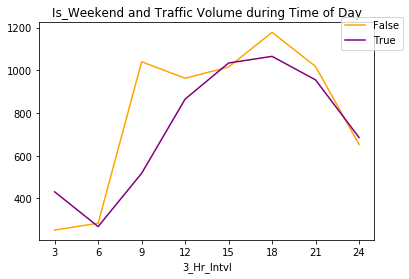

The sinusoidal resemblance is more apparent when you revert back to the 24 hour format, than the current format with 3 hours being binned together. #3

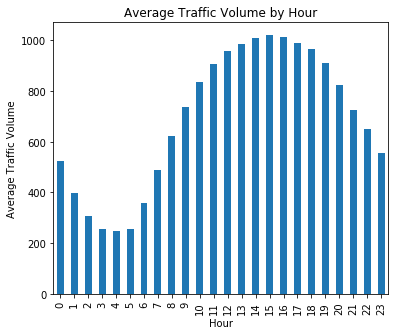

In terms of Boroughs, Manhattan has the highest traffic volumes. #15

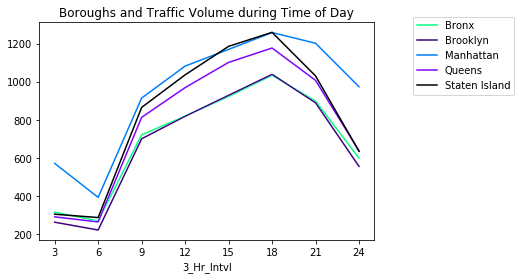

In terms of LandUses, the group with the highest traffic volume are street segments where the LandUse category 5 (Outside space) is the most common surrounding landuse category. Meanwhile, predominantly residential and business street segments seem to have the least traffic volume. LandUse Category 4 (Public institutions) seems to be missing from the chart, but that's actually because there were no street segments in the dataset where Public institutions was the most predominant surrounding building type #16

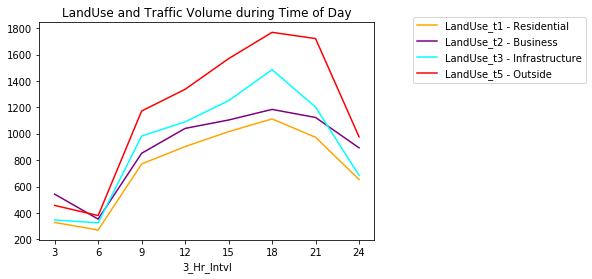

The following scatterplot shows Average Floor Count versus Traffic volume: #18

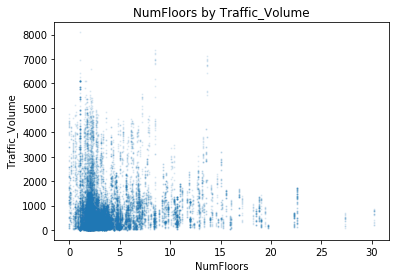

This is a bit surprising, because you'd originally expect that taller buildings means more urbanization, meaning busier streets and ***higher traffic volume***. After all, 

But as the scatterplot shows, street segments surrounded by more multi-storied buildings has less traffic volume. The opposing end is not true, however: street segments surrounded by more buildings with smaller floor-counts tend to vary in traffic volume. There's a lot of possible hypotheses that can be made to address this
* For example, a hypothesis could be that the urban density that comes with multi-story buildings discourage wide, open-spaced boulevards for heavy traffic.
* Another way to speculate is that when it comes to heavy urban density, commuting by road is not efficient, which brings leads to the next variable to account, subways.

The following scatterplot shows Subway proximity against Traffic Volume. Subway Proximity is a value showing how much nearby subway entrances there are to a current street segment. The lower SubwayProximity is, the further away you are from nearby subways. #19

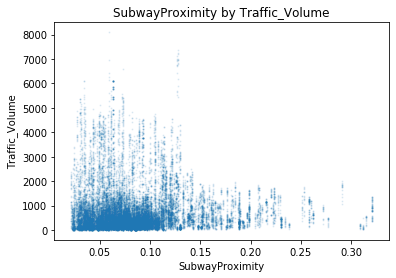

This shows that higher subwayProximity tends to have lower traffic volume, perhaps because people would rather take the subway (a staple of New York life) than add onto the road's congestion.

## Part 4: Prediction and Basic Machine Learning

The final part is seeing if NYC traffic can be predicted using the features used so far.

The target variable "Traffic_Volume" undergoes one last transformation:
* f(x) = log(x + 1)
    * Traffic Volume is a right-skewed distribution highest at 0. Logging turns it into a bell curve. The +1 prevents logging zero.
* Standard-scaled (aka Z-scoring)
    * Now as a bell curve shape, it gets z-scored
* Discretization as 3 categories:
    * Low, Medium, Heavy Traffic: any value below -1 or above 1 gets put into separate groups

Correlation Heatmap (Spearman) #32

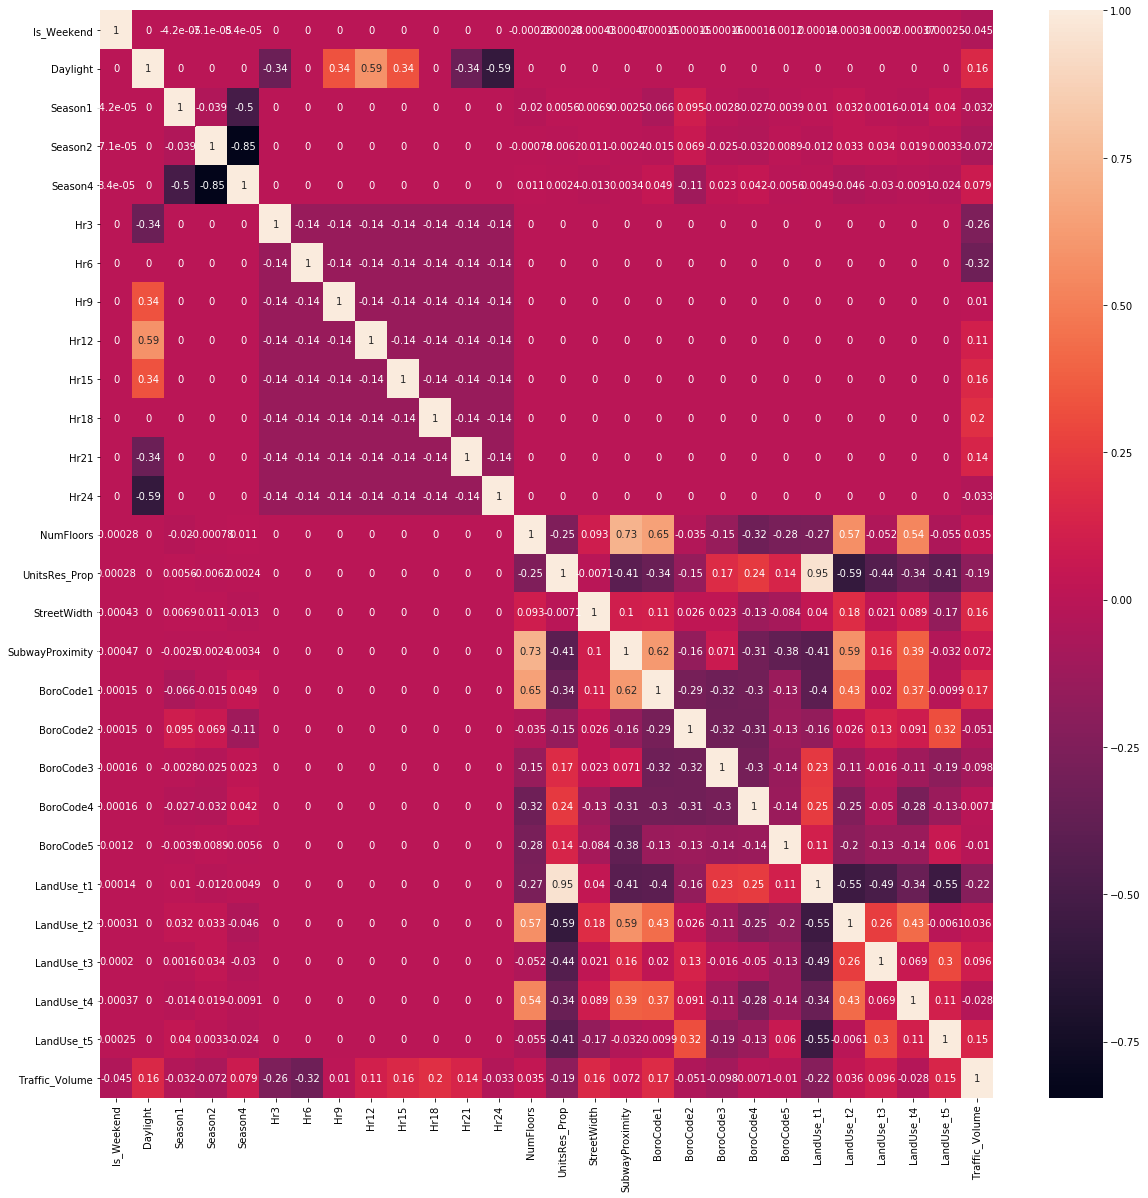

This is the point when unneeded columns could be dropped. At minimum, we actually only need the hours columns, and the landuse columns, which yield an accuracy rate of 86%.

The model used is a RandomForestClassifier with class_weights = balanced

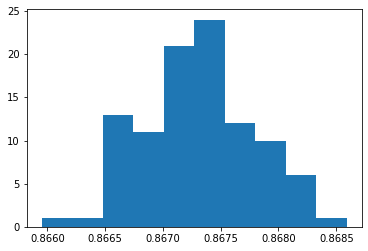